In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import os

# Step 1: Load the dataset and labels
X = np.load('dataset.npy')  # Assuming dataset.npy contains 2D or 3D images
y = np.load('labels.npy')    # Assuming labels.npy contains labels as class indices
print("Number of images used for training:",len(X))

Number of images used for training: 59995


In [2]:
# Normalize the data
X = X / 255.0  # Scale pixel values to [0, 1]

# Flatten the input if needed (i.e., if X is 2D/3D, flatten it into 1D per sample)
X = X.reshape(X.shape[0], -1)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)  # Ensure y is of type long for CrossEntropyLoss

# Step 2: Define the Neural Network
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))  # Hidden layer with sigmoid activation
        x = self.fc2(x)  # Output layer with raw logits (no activation)
        return x

input_size = X_tensor.shape[1]  # Flattened image size
hidden_size = 64
output_size = 10  # Number of classes

model = SimpleNN(input_size, hidden_size, output_size)

# Step 3: Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss expects raw logits, not softmax/sigmoid
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Step 4: Train the model
num_epochs = 1000
losses = []

for epoch in range(num_epochs):
    outputs = model(X_tensor)  # Forward pass
    loss = criterion(outputs, y)  # Compute loss with raw logits
    
    optimizer.zero_grad()  # Zero the gradients
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights
    
    losses.append(loss.item())
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [100/1000], Loss: 1.9611
Epoch [200/1000], Loss: 1.3612
Epoch [300/1000], Loss: 0.9806
Epoch [400/1000], Loss: 0.7791
Epoch [500/1000], Loss: 0.6608
Epoch [600/1000], Loss: 0.5836
Epoch [700/1000], Loss: 0.5292
Epoch [800/1000], Loss: 0.4888
Epoch [900/1000], Loss: 0.4576
Epoch [1000/1000], Loss: 0.4331


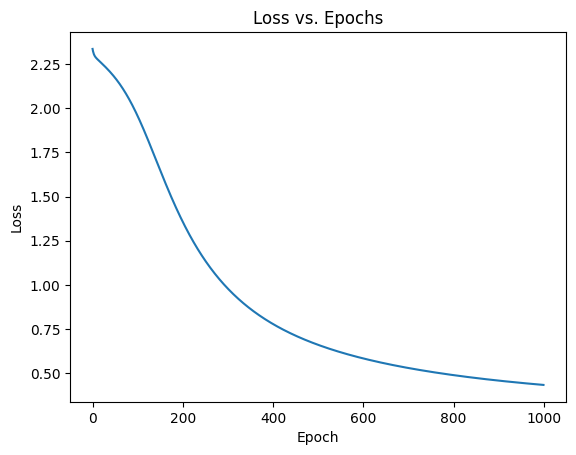

In [3]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.show()

In [4]:
# Step 6: Make predictions
with torch.no_grad():
    predictions = model(X_tensor)
    predicted_labels = torch.argmax(predictions, dim=1)

print("Predicted digits: ", predicted_labels)

# Step 7: Evaluate the Model
correct = (predicted_labels == y).sum().item()
accuracy = correct / y.size(0) * 100
print(f'Accuracy of the model: {accuracy:.2f}%')

# Step 8: Save the Model
torch.save(model.state_dict(), 'simple_nn_model.pth')
print("Model saved to 'simple_nn_model.pth'")

Predicted digits:  tensor([3, 0, 4,  ..., 9, 5, 1])
Accuracy of the model: 88.79%
Model saved to 'simple_nn_model.pth'


In [6]:
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
import os

# Step 1: Define the Neural Network
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))  # Hidden layer with sigmoid activation
        x = self.fc2(x)  # Output layer with raw logits (no activation)
        return x

# Step 2: Load the model
input_size = 784  # Adjust based on your flattened image size
hidden_size = 64
output_size = 10  # Number of classes

model = SimpleNN(input_size, hidden_size, output_size)
model.load_state_dict(torch.load('simple_nn_model.pth', weights_only=True))  # Load the saved model
model.eval()  # Set the model to evaluation mode

# Step 3: Predict Digits from Images Folder
def predict_from_images(image_folder):
    predictions = []
    
    for filename in os.listdir(image_folder):
        if filename.endswith('.png') or filename.endswith('.jpg'):  # Adjust based on your image format
            img = Image.open(os.path.join(image_folder, filename)).convert('L')  # Convert to grayscale
            img = img.resize((28, 28))  # Resize to 28x28 (adjust as needed)
            img = np.array(img).astype(np.float32) / 255.0  # Normalize
            img_tensor = torch.tensor(img).view(-1).unsqueeze(0)  # Flatten and add batch dimension
            
            with torch.no_grad():
                output = model(img_tensor)
                _, predicted = torch.max(output.data, 1)
                predictions.append(predicted.item())
                
    return predictions

# Example usage
predictions = predict_from_images('/home/sanat/Desktop/NN-Task/images')  # Adjust the path to your images folder
print("Predicted digits from images: ", predictions)

Predicted digits from images:  [6, 5, 3, 8, 8]
